## Multi-aperture telescope simulation sampler demonstration
Author: Ian Cunnyngham (Institute for Astronomy 2019,2020)

Simulates multi-aperture telescope optical performance with piston, tip, tilt actuation, atmospheres, etc. in HCIPy and returns samples in a format structured for deep learning applications

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hcipy
import joblib
from multi_aperture_psf import MultiAperturePSFSampler

%matplotlib inline

### Configure telescope / instrument

A few mirror configurations
- A simple unobstructed AEOS like aperture
- Best analog to  DASIE bench demo so far
- Keck-ish?  Just to show flexibility

In [4]:
# One big aperture with D=3.6m and central obscuraction 
nMir = 1
mir_centers = hcipy.CartesianGrid(np.array([[0], [0]]))
mir_diamater, pup_diamater = 3.6, 4
aper_config = ['circular_central_obstruction', mir_diamater, .3]

In [2]:
# DASIE bench-demo: 2.5m ring of 15 sub-apertures with D~=.5m 
nMir = 15
telescopeR = 1.25 # meters
mir_coords = hcipy.SeparatedCoords((np.array([telescopeR]), np.linspace(0, 2*np.pi, nMir+1)[:-1]))
mir_centers = hcipy.PolarGrid(mir_coords).as_('cartesian')
mir_diamater = .4975
pup_diamater = max(mir_centers.x.max() - mir_centers.x.min(), mir_centers.y.max() - mir_centers.y.min()) + mir_diamater
pup_diamater *= 1.05  # Add a little extra for edges, not convinced not cutting off
aper_config = ['circular', mir_diamater]

In [6]:
# Keck-ish?
nMir = 36
telescopeR = 10 # meters
mir_centers = hcipy.make_hexagonal_grid(1.6, 3, False)  # 1.6m between points, 3 rows, pack
mir_centers = hcipy.CartesianGrid(mir_centers[1:].T) # Remove center coordinate, reform
pup_diamater = 12
aper_config = ['hexagonal', 1.8, np.pi/2]

Setup additional configs which could be applied or omitted

In [3]:
## Spider config (normal x-shaped spider)
spider_config = {
    'width': .03175,     # pupil-plane meters
    #'angle': 0            # 0 to 90 degrees
    'random_angle': True  # Generate random angle each initialization
}

In [4]:
## Deforamble Mirror config
## (Uses hcipy.make_xinetics_influence_functions and hcipy.DeformableMirror)
# AEOS DM actuator pupil-plane spacing: Spacing = 9mm, Telescope = 3.6m, Beam diamater = 28.8cm
act_pup_spacing = .009*(3.6/.288)  # pupil-plane meters
# 35x35 actuators
dm_config=[35, act_pup_spacing]

In [5]:
## Detector noise characteristics
## Uses hcipy.NoisyDetector:  https://docs.hcipy.org/0.3.1/api/hcipy.optics.NoisyDetector.html
# Makes the most sense if supplying integrated-photon-flux for each observation
detector_config = {
    'read_noise': 10,
    'include_photon_noise': True,
}

Bring together with the rest of the configuration for MultiAperturePSFSampler

In [6]:
mas_setup = {
    'mirror_config': {
        'pupil_res': 256,       # Pupil plane resolution
        'piston_scale': 1e-6,   # meters
        'tip_tilt_scale': 1e-6,  # meters
        'positions': mir_centers,
        'aperture_config': aper_config,
        'pupil_extent': pup_diamater,
        
        ## Comment out if you don't want spiders
        'spider_config': spider_config,
        
        ## Uncomment these if you want DM approximation of PTT
#         'dm_config': dm_config,
#         'aprox_ptt_wih_dm': True,
    },
    'filter_configs': [   
        {  ## "Sloan i" ...ish
            'central_lam': .75e-6,    # meters
            'focal_res': 256,
            'focal_extent': 0.0207 * 256,  # Plate scale of .0207 arcsec/pix * resolution
            'frac_bandwidth': .172,
            'num_samples': 5,
            
            # Won't be applied without integrated photon flux for each observation
            'detector_config': detector_config
        },
    ] ,
    'extra_processing': {
        ## Normalizes PSFs so perfect PSF is 1.0 at peak (Default: True) (not sure units of non-normalized)
        #'max_inten_norm': False,
        
        ## Take DFT of outputs and include real and imaginary parts as channels for DNNs (Default: False)
        #'include_fft': True,
        
        ## Scales output with np.power(output, pow_scale) 
        ## ( Useful for training DNNs )
        #'pow_scale': .2,
    }
}

In [7]:
# Save config for use with Dasie Gym environment
# (Probably don't want use DM version until the end of training
#  It is pretty close to the "real" PTT actuation, but takes much longer to generate)
joblib.dump(mas_setup, 'bench_demo.pkl')

['bench_demo.pkl']

### Test out sampler

In [8]:
mas_psf_sampler = MultiAperturePSFSampler(**mas_setup)

In [9]:
# Make a DM version to compare in parallel
import copy
mas_dm_setup = copy.deepcopy(mas_setup)
mas_dm_setup['mirror_config']['dm_config'] = dm_config
mas_dm_setup['mirror_config']['aprox_ptt_wih_dm'] = True
mas_dm_setup['mirror_config']['spider_config']['random_angle'] = False
mas_dm_setup['mirror_config']['spider_config']['angle'] = mas_psf_sampler.spider_angle
mas_psf_dm_sampler = MultiAperturePSFSampler(**mas_dm_setup)

In [10]:
# Some helpers to make plots below prettier
f_ext = mas_setup['filter_configs'][0]['focal_extent']
ang_extent = [-.5*f_ext, .5*f_ext, -.5*f_ext, .5*f_ext]

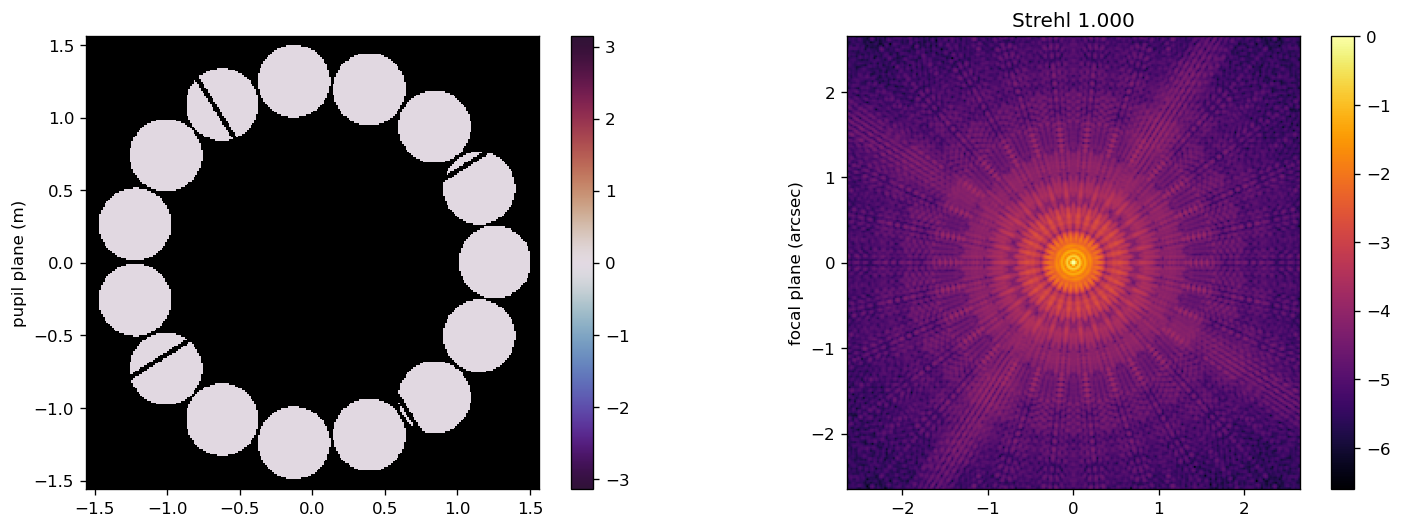

In [12]:
x, y_fit_atmos, strehls = mas_psf_sampler.sample(meas_strehl=True)
psf_filter1 = x[..., 0]

fig = plt.figure(figsize=[15,5], dpi=120)
plt.subplot(121)
awf1 = mas_psf_sampler.getPhaseScreen()
hcipy.imshow_field(awf1, mask=mas_psf_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
plt.ylabel('pupil plane (m)')
plt.colorbar()

plt.subplot(122)
im = plt.imshow(np.log10(psf_filter1), cmap='inferno', extent=ang_extent) # vmin=log_min, 
plt.title(f'Strehl {strehls[0]:.03f}')
plt.ylabel('focal plane (arcsec)')
cbar = plt.colorbar(im)

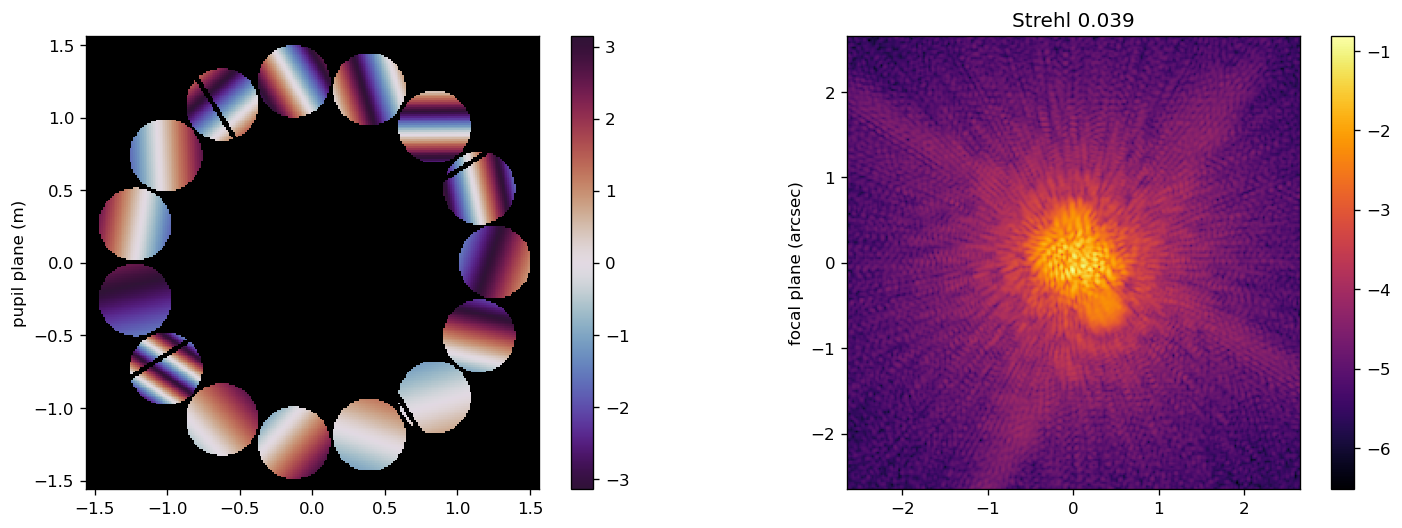

In [13]:
# Generate some random PTT errors and generate PSFS
rand_errs = np.random.normal(0, .5, (nMir, 3))
x, y_fit_atmos, strehls = mas_psf_sampler.sample(rand_errs, meas_strehl=True)
psf_filter1 = x[..., 0]

fig = plt.figure(figsize=[15,5], dpi=120)
plt.subplot(121)
awf1 = mas_psf_sampler.getPhaseScreen()
hcipy.imshow_field(awf1, mask=mas_psf_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
plt.ylabel('pupil plane (m)')
plt.colorbar()

plt.subplot(122)
im = plt.imshow(np.log10(psf_filter1), cmap='inferno', extent=ang_extent) # vmin=log_min, 
plt.title(f'Strehl {strehls[0]:.03f}')
plt.ylabel('focal plane (arcsec)')
cbar = plt.colorbar(im)

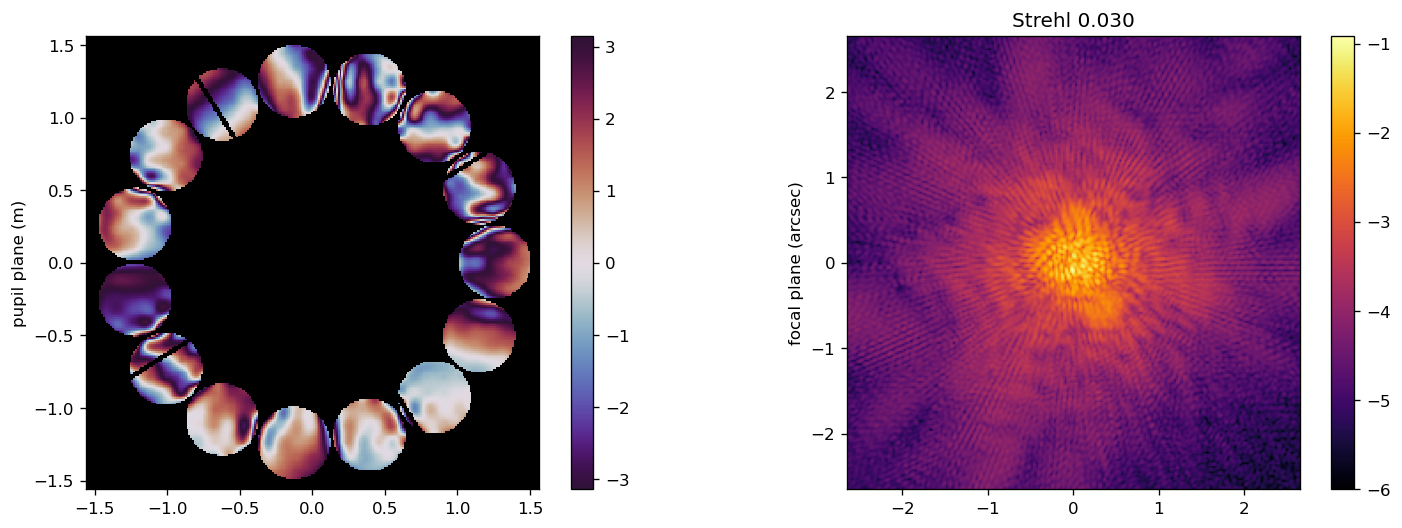

In [14]:
# DM version
x, y_fit_atmos, strehls = mas_psf_dm_sampler.sample(rand_errs, meas_strehl=True)
psf_filter1 = x[..., 0]

fig = plt.figure(figsize=[15,5], dpi=120)
plt.subplot(121)
awf1 = mas_psf_dm_sampler.getPhaseScreen()
hcipy.imshow_field(awf1, mask=mas_psf_dm_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
plt.ylabel('pupil plane (m)')
plt.colorbar()

plt.subplot(122)
im = plt.imshow(np.log10(psf_filter1), cmap='inferno', extent=ang_extent) # vmin=log_min, 
plt.title(f'Strehl {strehls[0]:.03f}')
plt.ylabel('focal plane (arcsec)')
cbar = plt.colorbar(im)

This actuation might seem a bit messy in the pupil plane, but we'll see below it does a decent job at approximating PTT correction to the atmosphere.  (Also, it's about the best we can do with limited DM resolution)

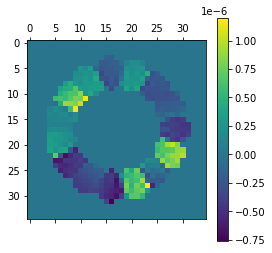

In [15]:
# Look at actual DM actuatation to make above (if enabled)
plt.matshow(mas_psf_dm_sampler.dm.actuators.reshape((35, 35)))
plt.colorbar()

### Generate some atmospheres

Pick either multi-layer or single-layer

In [16]:
fried_params = .20, .550e-6  # r0 (meters), wavelength measured at (meters)
outer_scale = 200            # (meters)

In [17]:
# Multi-layer atmosphere
layers = hcipy.make_standard_atmospheric_layers(mas_psf_sampler.pupil_grid, outer_scale)
atmos = hcipy.MultiLayerAtmosphere(layers, scintilation=False)
atmos.Cn_squared = hcipy.Cn_squared_from_fried_parameter(*fried_params)
atmos.reset()

/home/ian/anaconda3/lib/python3.8/site-packages/hcipy/util/spectral_noise.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  S_1 = np.add.reduce(np.ix_(*S_1))
/home/ian/anaconda3/lib/python3.8/site-packages/hcipy/util/spectral_noise.py:170: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  S_2 = np.add.reduce(np.ix_(*S_2))
/home/ian/anaconda3/lib/python3.8/site-packages/hcipy/atmosphere/atmospheric_model.py:181: UserWarning: Please use the correct spelling for scintillation.
  warnings.warn('Please use the correct spelling for scintillation.')


In [6]:
# Single layer atmosphere
cn2 = hcipy.Cn_squared_from_fried_parameter(*fried_params)
atmos = hcipy.InfiniteAtmosphericLayer(mas_psf_sampler.pupil_grid, cn2, outer_scale, 10, 100)

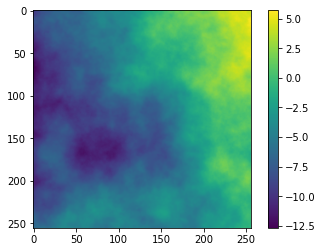

In [18]:
# Plot a phase screen at 1 micron
atmos_1mic_phase = atmos.phase_for(1e-6)
plt.imshow(atmos_1mic_phase.reshape(mas_psf_sampler.pupil_grid.shape)) # With multi-atmos
plt.colorbar()

### Apply atmosphere to focal-plane and show piston, tip, tilt correction for it

When atmosphere is passed in, optimal PTT correction is fit to the pupil and returned sclaed to actuation scale set in sampler (piston_scale and tip_tilt_scale)

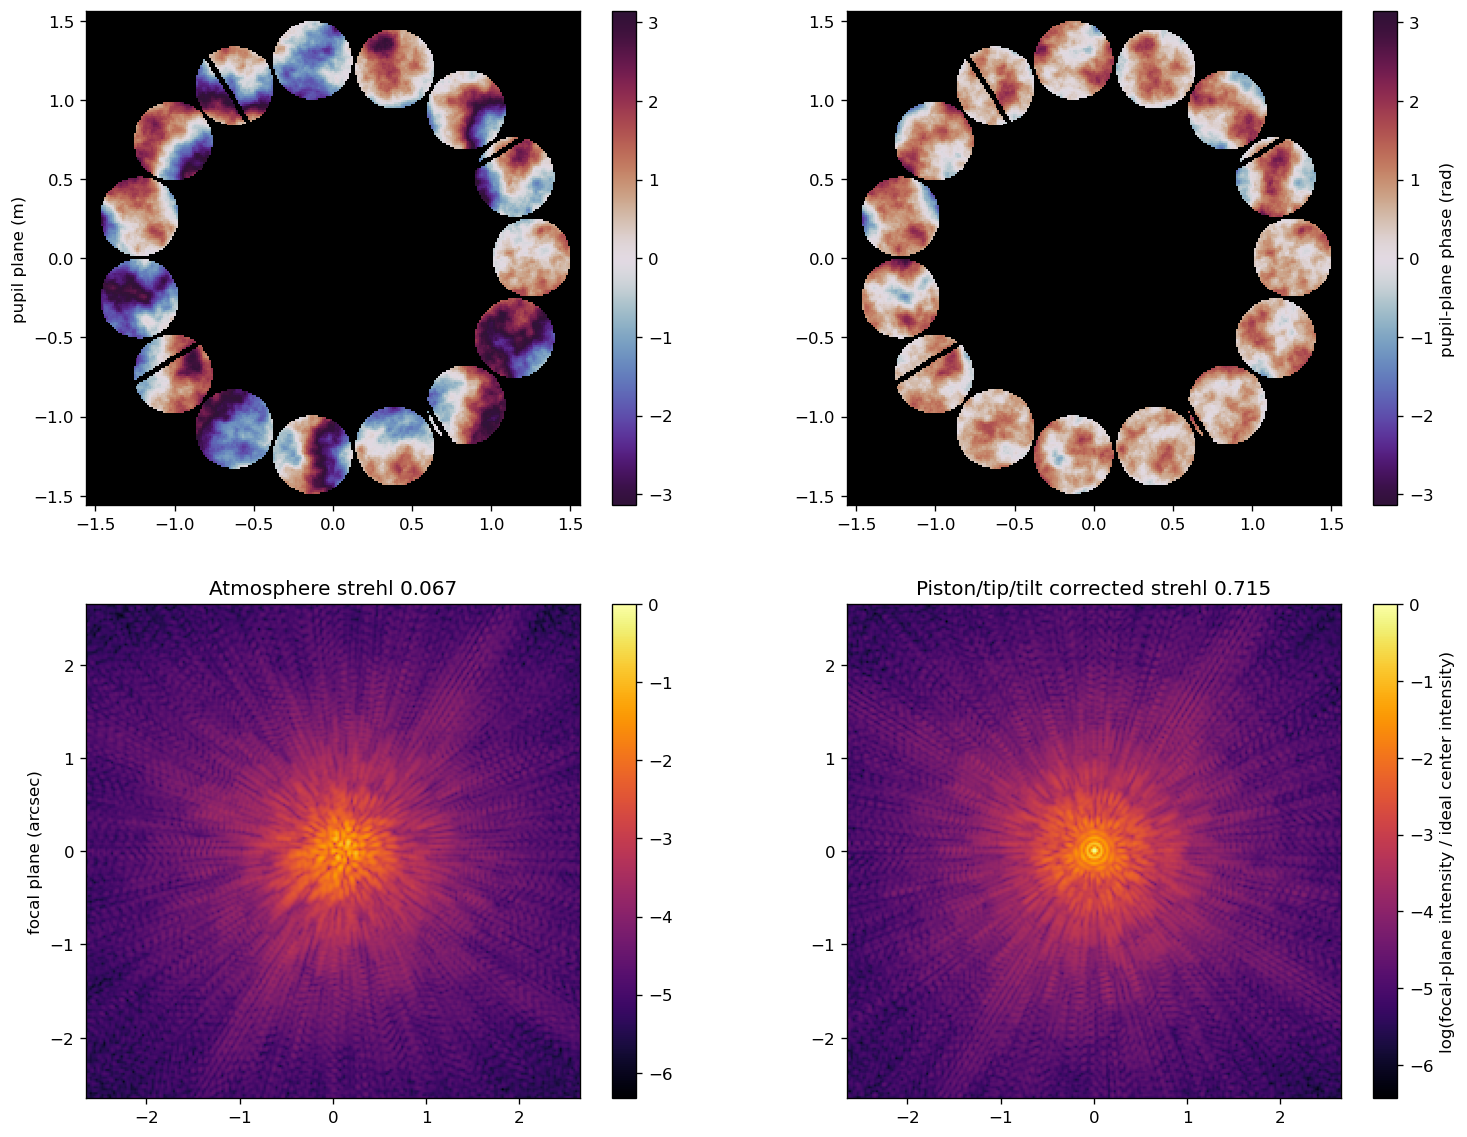

In [19]:
# Plot pupil and PSF with this atmosphere
x, y_fit_atmos, strehls = mas_psf_sampler.sample(atmos=atmos, meas_strehl=True)
psf_filter1 = x[..., 0]

fig = plt.figure(figsize=[15,12], dpi=120)

plt.subplot(221)
awf1 = mas_psf_sampler.getPhaseScreen(atmos)
hcipy.imshow_field(awf1, mask=mas_psf_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
plt.ylabel('pupil plane (m)')
plt.colorbar()

plt.subplot(223)
im = plt.imshow(np.log10(psf_filter1), vmax=0, cmap='inferno', extent=ang_extent) # vmin=log_min,
plt.ylabel('focal plane (arcsec)')
plt.title(f'Atmosphere strehl {strehls[0]:.03f}')
cbar = plt.colorbar(im)

# Plot pupil and PSF with atmosphere and PTT correction
x, _, cor_strehls = mas_psf_sampler.sample(-y_fit_atmos, atmos=atmos, meas_strehl=True)
psf_filter3 = x[..., 0]

plt.subplot(222)
awf3 = mas_psf_sampler.getPhaseScreen(atmos)
hcipy.imshow_field(awf3, mask=mas_psf_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
cbar = plt.colorbar()
cbar.set_label('pupil-plane phase (rad)')

plt.subplot(224)
im = plt.imshow(np.log10(psf_filter3), vmax=0, cmap='inferno', extent=ang_extent) # vmin=log_min,
plt.title(f'Piston/tip/tilt corrected strehl {cor_strehls[0]:.03f}')
cbar = plt.colorbar(im)
cbar.set_label('log(focal-plane intensity / ideal center intensity)')
#plt.suptitle(f'Simulated atmosphere (r0 = {fried_params[0]*100} cm)')

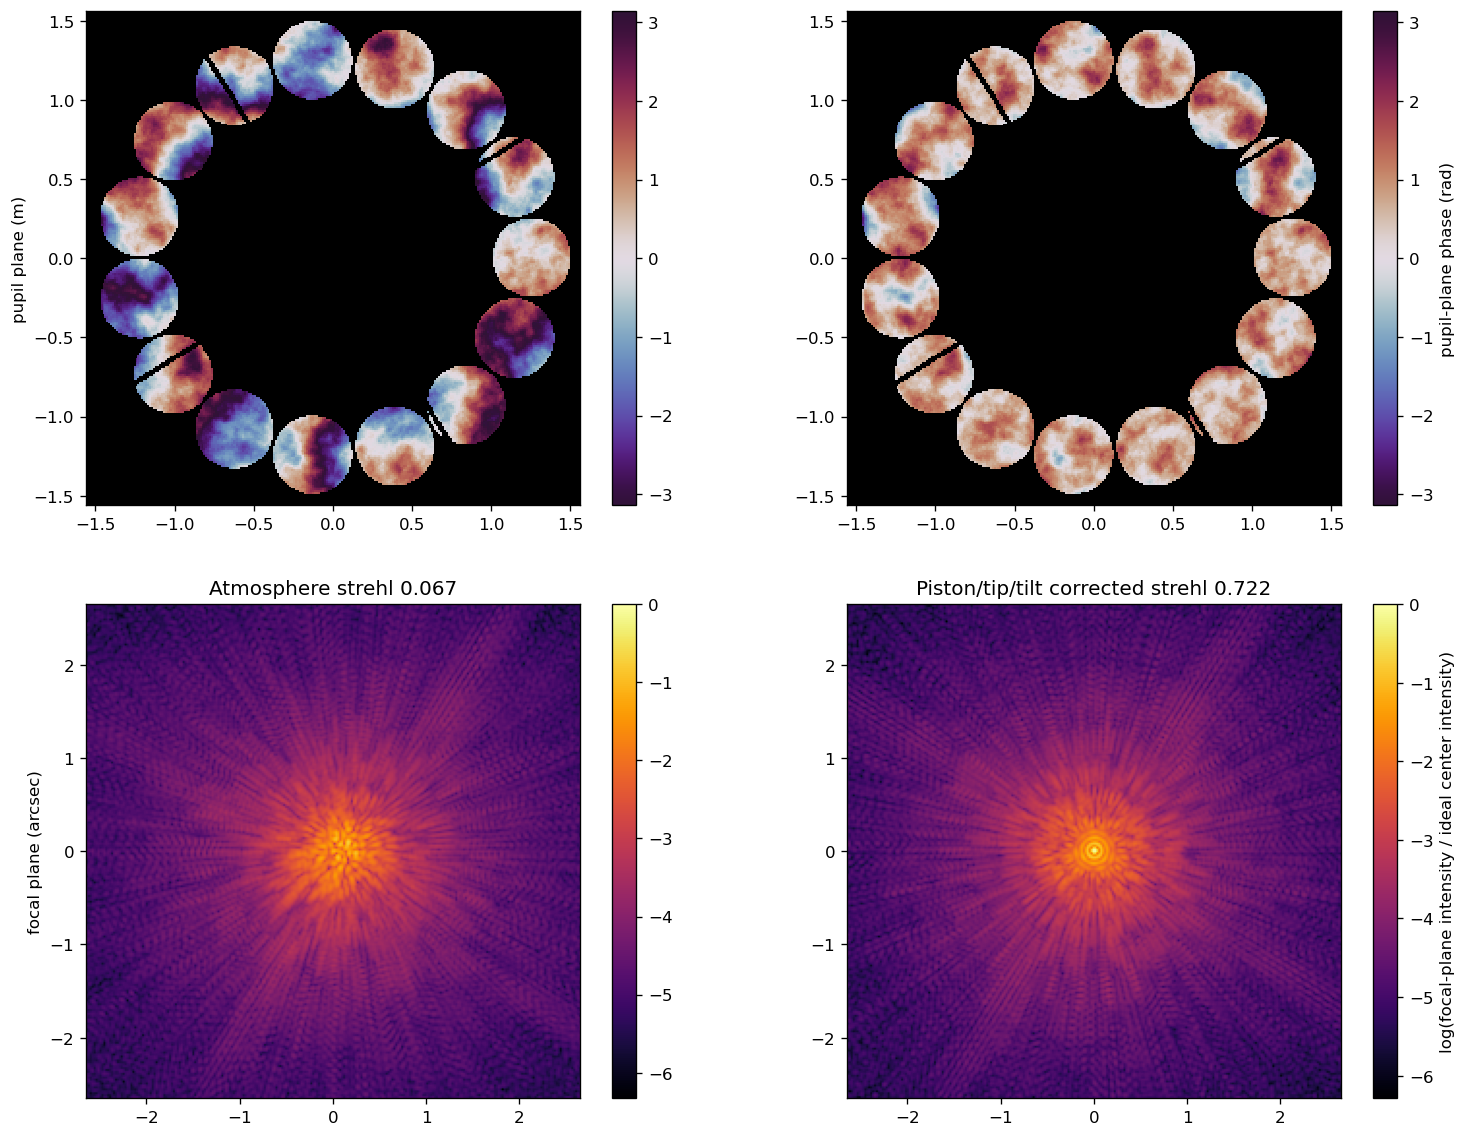

In [20]:
# DM Version
x, y_fit_atmos, strehls = mas_psf_dm_sampler.sample(atmos=atmos, meas_strehl=True)
psf_filter1 = x[..., 0]

fig = plt.figure(figsize=[15,12], dpi=120)

plt.subplot(221)
awf1 = mas_psf_dm_sampler.getPhaseScreen(atmos)
hcipy.imshow_field(awf1, mask=mas_psf_dm_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
plt.ylabel('pupil plane (m)')
plt.colorbar()

plt.subplot(223)
im = plt.imshow(np.log10(psf_filter1), vmax=0, cmap='inferno', extent=ang_extent) # vmin=log_min,
plt.ylabel('focal plane (arcsec)')
plt.title(f'Atmosphere strehl {strehls[0]:.03f}')
cbar = plt.colorbar(im)

# Plot pupil and PSF with atmosphere and PTT correction
x, _, cor_strehls = mas_psf_dm_sampler.sample(-y_fit_atmos, atmos=atmos, meas_strehl=True)
psf_filter3 = x[..., 0]

plt.subplot(222)
awf3 = mas_psf_dm_sampler.getPhaseScreen(atmos)
hcipy.imshow_field(awf3, mask=mas_psf_dm_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
cbar = plt.colorbar()
cbar.set_label('pupil-plane phase (rad)')

plt.subplot(224)
im = plt.imshow(np.log10(psf_filter3), vmax=0, cmap='inferno', extent=ang_extent) # vmin=log_min,
plt.title(f'Piston/tip/tilt corrected strehl {cor_strehls[0]:.03f}')
cbar = plt.colorbar(im)
cbar.set_label('log(focal-plane intensity / ideal center intensity)')
#plt.suptitle(f'Simulated atmosphere (r0 = {fried_params[0]*100} cm)')

### Convolve PSF with an image 

If you pass in an image to conolve with PSF, sampler returns that instead of PSFs.  Any extra_processing specified in sampler (intensity power scaling, adding noise, generating FFTs) is applied to these images instead of the PSF

Note: filter resolution must match image and should be careful to set angular FOV and image pixel scale

In [21]:
orig_im = plt.imread('sample_image.png')

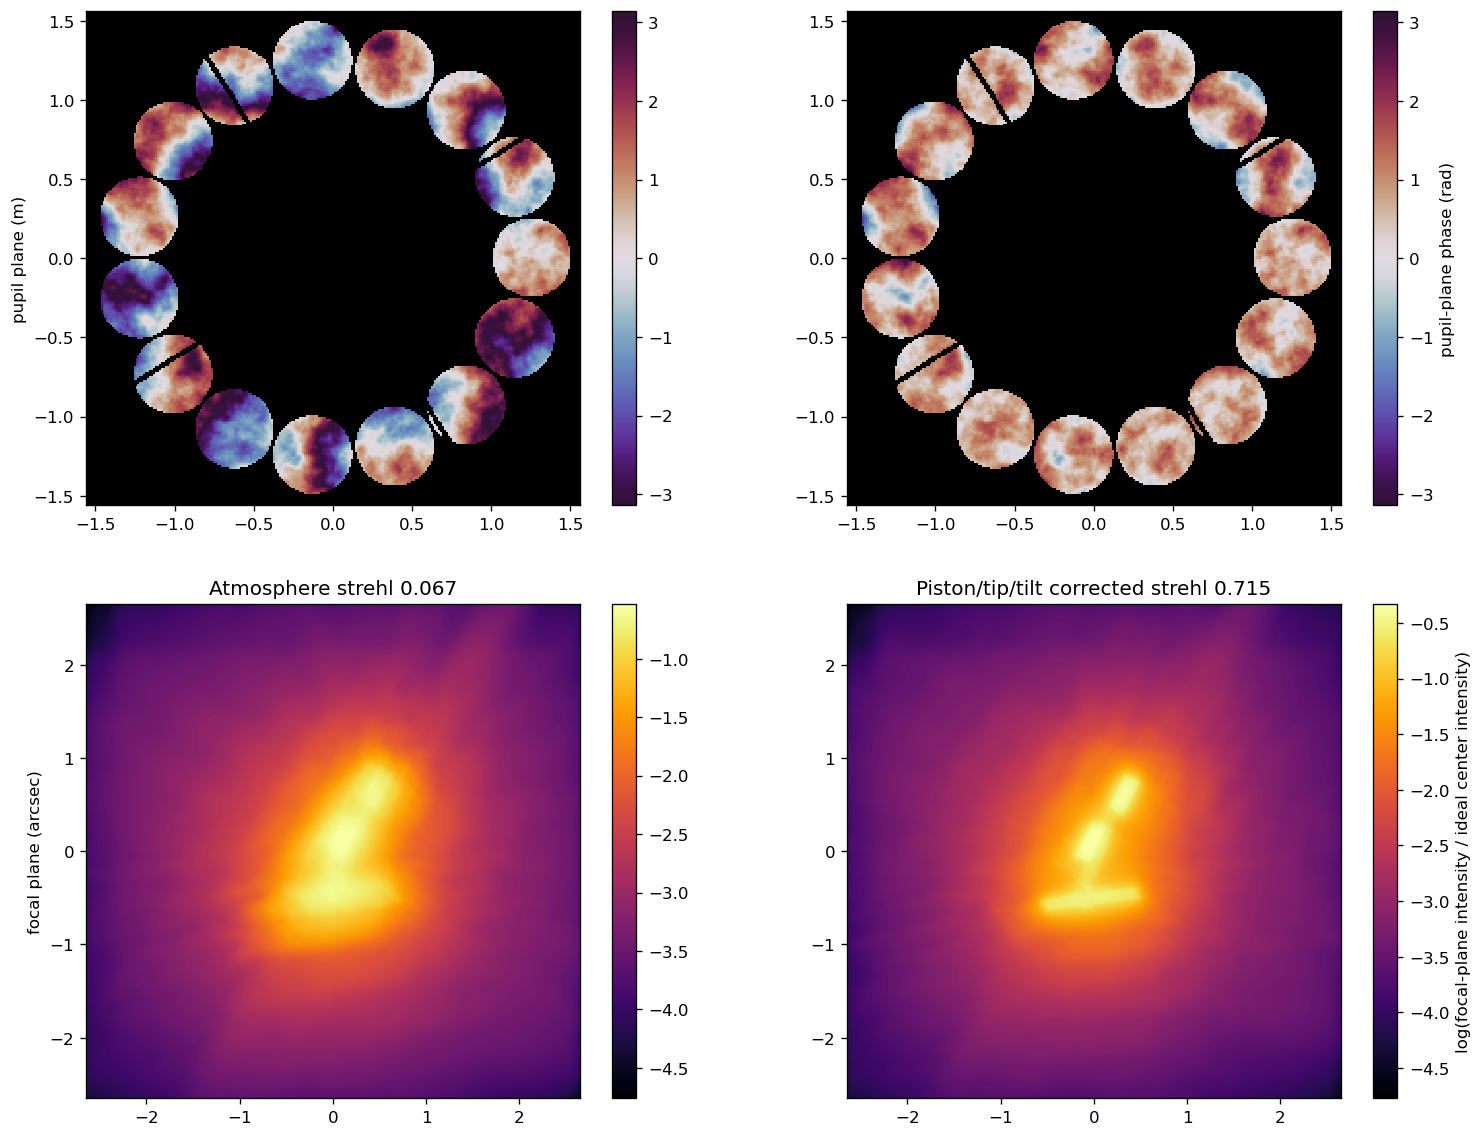

In [22]:
# Convolve image
x, y_fit_atmos, strehls = mas_psf_sampler.sample(
    convolve_im=orig_im, 
    atmos=atmos, 
    meas_strehl=True
)
psf_filter1 = x[..., 0]

fig = plt.figure(figsize=[15,12], dpi=120)

plt.subplot(221)
awf1 = mas_psf_sampler.getPhaseScreen(atmos)
hcipy.imshow_field(awf1, mask=mas_psf_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
plt.ylabel('pupil plane (m)')
plt.colorbar()

plt.subplot(223)
im = plt.imshow(np.log10(psf_filter1), cmap='inferno', extent=ang_extent) # vmax=0, vmin=log_min,
plt.ylabel('focal plane (arcsec)')
plt.title(f'Atmosphere strehl {strehls[0]:.03f}')
cbar = plt.colorbar(im)

# Plot pupil and PSF with atmosphere and PTT correction
x, _, cor_strehls = mas_psf_sampler.sample(
    -y_fit_atmos, 
    convolve_im=orig_im, 
    atmos=atmos, 
    meas_strehl=True)
psf_filter3 = x[..., 0]

plt.subplot(222)
awf3 = mas_psf_sampler.getPhaseScreen(atmos)
hcipy.imshow_field(awf3, mask=mas_psf_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
cbar = plt.colorbar()
cbar.set_label('pupil-plane phase (rad)')

plt.subplot(224)
im = plt.imshow(np.log10(psf_filter3), cmap='inferno', extent=ang_extent) # vmin=log_min,
plt.title(f'Piston/tip/tilt corrected strehl {cor_strehls[0]:.03f}')
cbar = plt.colorbar(im)
cbar.set_label('log(focal-plane intensity / ideal center intensity)')
#plt.suptitle(f'Simulated atmosphere (r0 = {fried_params[0]*100} cm)')

### Add detector / photon noise

Total object brightness is specified as integrated-photon-flux (photons / m^2)

I decided on this because we can work backwards from this depending on specifics of instruement / object magnitude later

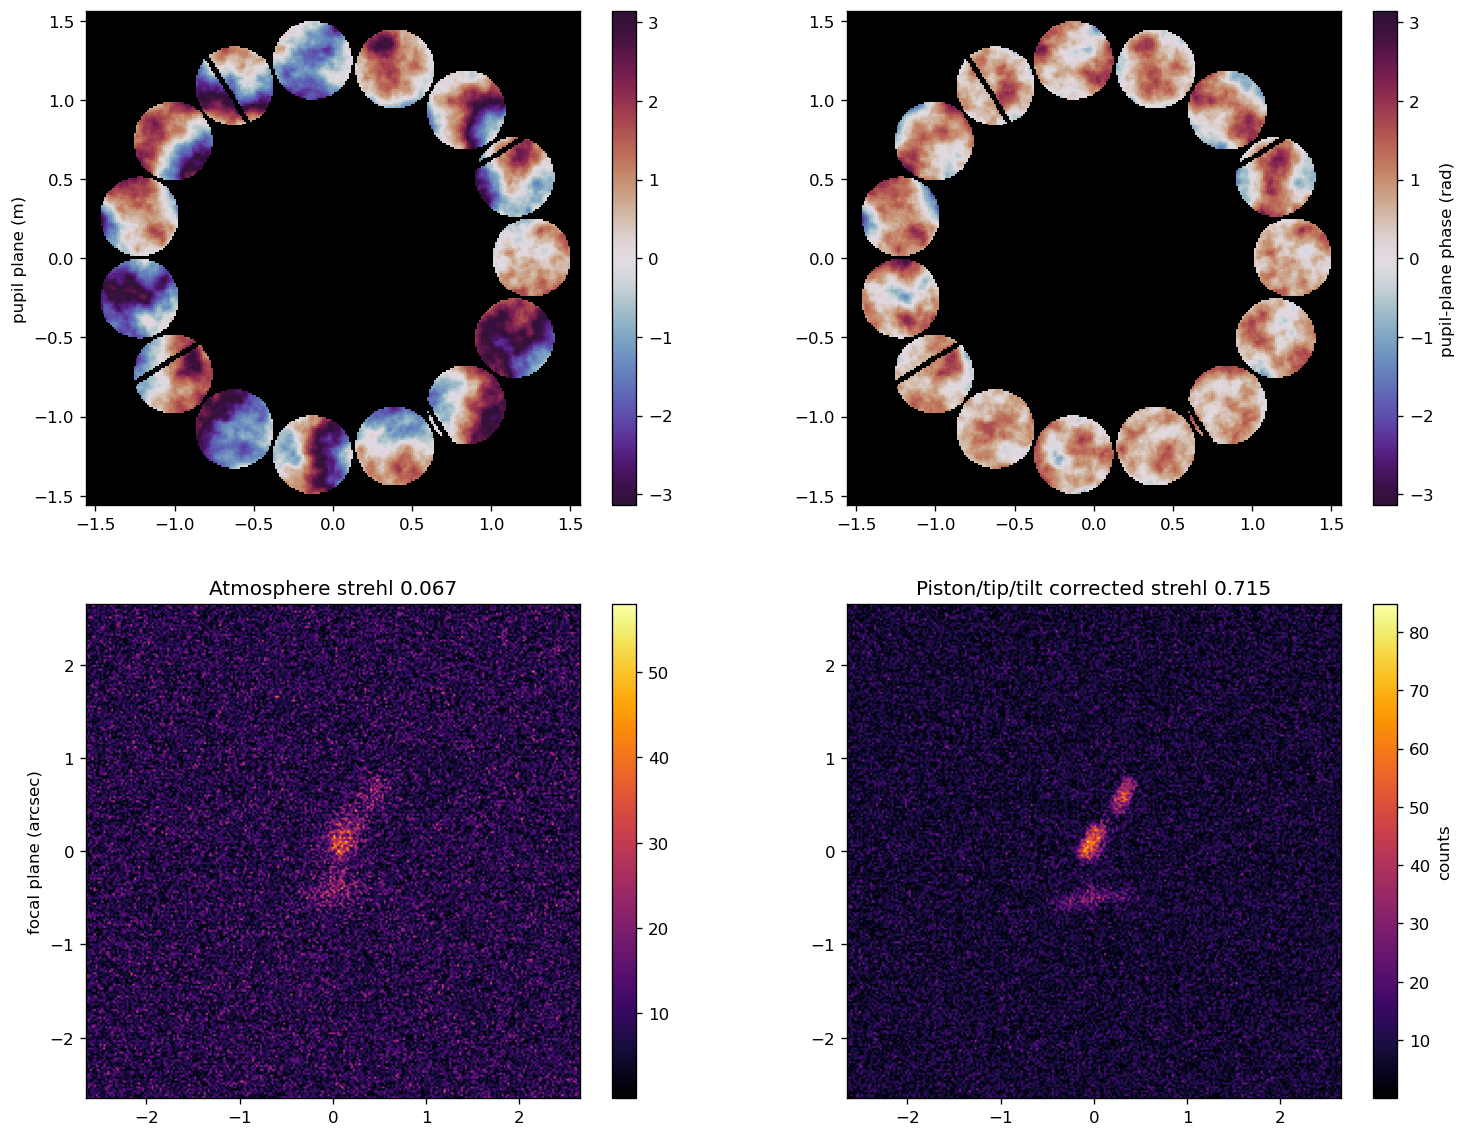

In [23]:
# Integrated photon flux
int_phot_flux = 1e4

# Add noise
x, y_fit_atmos, strehls = mas_psf_sampler.sample(
    convolve_im=orig_im, 
    int_phot_flux=int_phot_flux,
    atmos=atmos, 
    meas_strehl=True
)
psf_filter1 = x[..., 0]

fig = plt.figure(figsize=[15,12], dpi=120)

plt.subplot(221)
awf1 = mas_psf_sampler.getPhaseScreen(atmos)
hcipy.imshow_field(awf1, mask=mas_psf_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
plt.ylabel('pupil plane (m)')
plt.colorbar()

plt.subplot(223),
im = plt.imshow(psf_filter1, cmap='inferno', extent=ang_extent) 
plt.ylabel('focal plane (arcsec)')
plt.title(f'Atmosphere strehl {strehls[0]:.03f}')
cbar = plt.colorbar(im)

# Plot pupil and PSF with atmosphere and PTT correction
x, _, cor_strehls = mas_psf_sampler.sample(
    -y_fit_atmos, 
    convolve_im=orig_im, 
    int_phot_flux=int_phot_flux,
    atmos=atmos, 
    meas_strehl=True)
psf_filter3 = x[..., 0]

plt.subplot(222)
awf3 = mas_psf_sampler.getPhaseScreen(atmos)
hcipy.imshow_field(awf3, mask=mas_psf_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
cbar = plt.colorbar()
cbar.set_label('pupil-plane phase (rad)')

plt.subplot(224)
# im = plt.imshow(np.log10(psf_filter3), cmap='inferno', extent=ang_extent) # vmin=log_min,
im = plt.imshow(psf_filter3, cmap='inferno', extent=ang_extent) 
plt.title(f'Piston/tip/tilt corrected strehl {cor_strehls[0]:.03f}')
cbar = plt.colorbar(im)
cbar.set_label('counts')

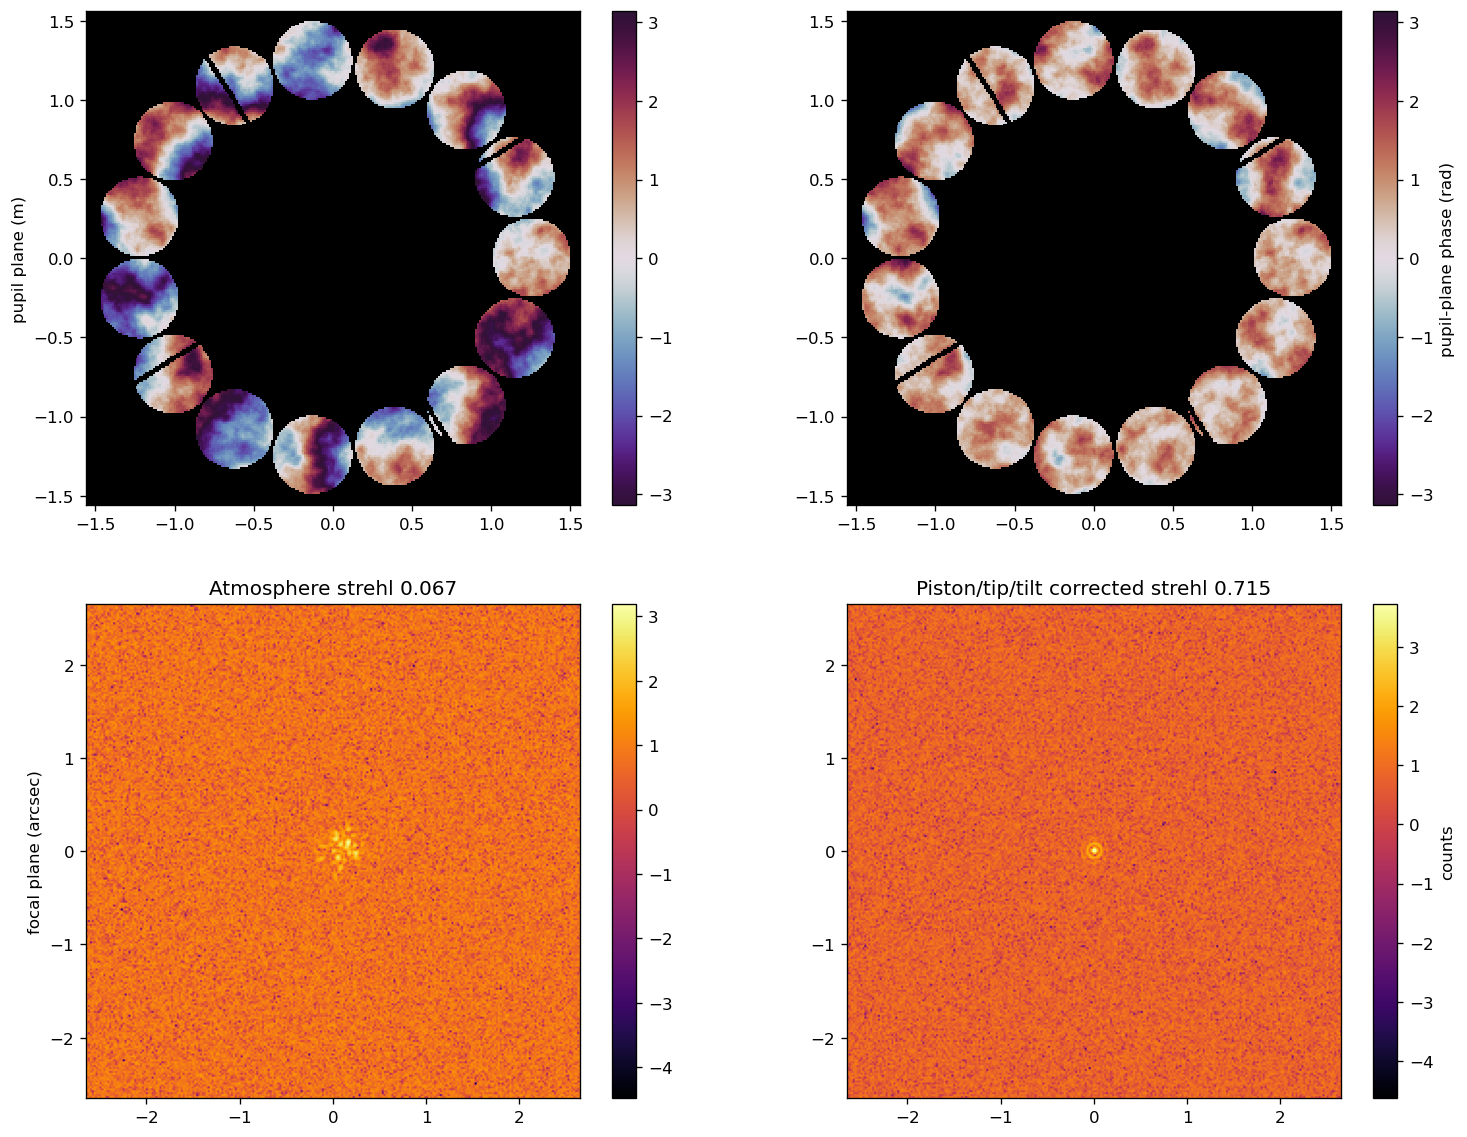

In [24]:
# Same thing, but just the PSF / a completely unresolved object

# Integrated photon flux
int_phot_flux = 1e4

# Add noise
x, y_fit_atmos, strehls = mas_psf_sampler.sample(
    int_phot_flux=int_phot_flux,
    atmos=atmos, 
    meas_strehl=True
)
psf_filter1 = x[..., 0]

fig = plt.figure(figsize=[15,12], dpi=120)

plt.subplot(221)
awf1 = mas_psf_sampler.getPhaseScreen(atmos)
hcipy.imshow_field(awf1, mask=mas_psf_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
plt.ylabel('pupil plane (m)')
plt.colorbar()

plt.subplot(223)
im = plt.imshow(np.log10(psf_filter1), cmap='inferno', extent=ang_extent) # vmin=log_min,
plt.ylabel('focal plane (arcsec)')
plt.title(f'Atmosphere strehl {strehls[0]:.03f}')
cbar = plt.colorbar(im)

# Plot pupil and PSF with atmosphere and PTT correction
x, _, cor_strehls = mas_psf_sampler.sample(
    -y_fit_atmos, 
    int_phot_flux=int_phot_flux,
    atmos=atmos, 
    meas_strehl=True)
psf_filter3 = x[..., 0]

plt.subplot(222)
awf3 = mas_psf_sampler.getPhaseScreen(atmos)
hcipy.imshow_field(awf3, mask=mas_psf_sampler.aper, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi)
cbar = plt.colorbar()
cbar.set_label('pupil-plane phase (rad)')

plt.subplot(224)
im = plt.imshow(np.log10(psf_filter3), cmap='inferno', extent=ang_extent) # vmin=log_min,
plt.title(f'Piston/tip/tilt corrected strehl {cor_strehls[0]:.03f}')
cbar = plt.colorbar(im)
cbar.set_label('counts')